**Mid-term Project: Implementing Object Detection on a Dataset**

# **Importing Dataset**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uhjoV3WNT5LUQzPsvxmG")
project = rf.workspace("test-kqntz").project("marul-mucm2")
version = project.version(2)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to marul-2 in yolov5pytorch:: 100%|██████████| 876/876 [00:00<00:00, 2737.83it/s]


# Import COCO.NAMES

In [ ]:
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names -O /content/coco.names

--2024-11-02 18:22:50--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘/content/coco.names’

/content/coco.names 100%[===================>]     625  --.-KB/s    in 0s      

2024-11-02 18:22:50 (36.9 MB/s) - ‘/content/coco.names’ saved [625/625]



# Installing Ultralytics for YOLO MODEL

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 14.8 MB/s eta 0:00:00


# Installing Libraries

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Load YOLO MODEL

In [ ]:
# Install required packages
!pip install -q ultralytics  # If YOLO model comes from ultralytics

# Import libraries
from ultralytics import YOLO
import glob
import os


# Load the YOLO model
yolo_model = YOLO('yolov8n.pt')

# Load class names
with open('/content/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Classes loaded:", classes)


Classes loaded: ['lettuce']


# Image Path

In [ ]:
# Get image paths for the dataset
image_paths = glob.glob('/content/Lettuce/train/images/*.jpg')
print("Found images:", image_paths[:5])  # Display the first 5 image paths




Found images: ['/content/Lettuce/train/images/IMG_8721_jpg.rf.dc21b5730dc3bf6eb322c32fef6c3910.jpg', '/content/Lettuce/train/images/IMG_0749_jpg.rf.f7d00e37bae220b4b20abc961523b049.jpg', '/content/Lettuce/train/images/97_JPG_jpg.rf.f0ff7e60e9b7c93cdd703b669ca4edfc.jpg', '/content/Lettuce/train/images/Image_72_jpg.rf.dcbce663c6cc5de596a8f012751159e7.jpg', '/content/Lettuce/train/images/24_JPG_jpg.rf.1d5221437ef96591fa20d9af182122f9.jpg']


# Image Preprocessing

In [ ]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(640, 640)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    # Resize and normalize image
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / 255.0
    return image_normalized

# Preprocess all images
processed_images = [preprocess_image(path) for path in image_paths]
print("Processed images:", len(processed_images))


Processed images: 366


# Object Detection

In [ ]:
# Function to detect objects in an image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = yolo_model.predict(source=image_rgb)

    print(f"Detected {len(results)} objects in {image_path}")

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = box.cls[0].cpu().numpy()

            if 0 <= int(cls) < len(classes):
                label = f"{classes[int(cls)]}: {conf:.2f}"
            else:
                print(f"Warning: Class ID {int(cls)} not found in coco.names")
                label = f"Class {int(cls)}: {conf:.2f}"

            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image_rgb


# Set training parameters and Training Model

In [ ]:

train_params = {
    "data": "/content/Lettuce/data.yaml",
    "epochs": 10,  # Number of training epochs
    "batch": 16,   # Batch size
    "imgsz": 640,  # Image size for training
}

# Train the model
yolo_model.train(**train_params)


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Lettuce/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/Lettuce/train/labels... 366 images, 0 backgrounds, 0 corrupt: 100%|██████████| 366/366 [00:00<00:00, 1021.94it/s]

train: New cache created: /content/Lettuce/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 33, len(boxes) = 516. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Lettuce/valid/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 792.34it/s]

val: New cache created: /content/Lettuce/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 41. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.8858      2.363      1.534         15        640: 100%|██████████| 23/23 [05:14<00:00, 13.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.57s/it]

                   all         36         41      0.859      0.445      0.702       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.8816       1.71      1.472         53        640: 100%|██████████| 23/23 [05:22<00:00, 14.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

                   all         36         41      0.886      0.366      0.838      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.8831      1.518      1.452         34        640: 100%|██████████| 23/23 [05:11<00:00, 13.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.47s/it]

                   all         36         41       0.91      0.739      0.883      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.9251      1.451      1.501         16        640: 100%|██████████| 23/23 [05:29<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.54s/it]

                   all         36         41      0.877      0.872      0.864      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.8813      1.273      1.443         19        640: 100%|██████████| 23/23 [05:15<00:00, 13.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.97s/it]

                   all         36         41      0.895      0.829      0.883      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.8205      1.211       1.36         15        640: 100%|██████████| 23/23 [05:20<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.15s/it]

                   all         36         41       0.86      0.749      0.857      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.7446      1.048      1.309         18        640: 100%|██████████| 23/23 [05:12<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.10s/it]

                   all         36         41      0.838      0.881      0.914      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.7215     0.9166      1.277         15        640: 100%|██████████| 23/23 [05:18<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]

                   all         36         41       0.94      0.902      0.931      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.6845     0.8504      1.238         18        640: 100%|██████████| 23/23 [05:18<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.56s/it]

                   all         36         41      0.944      0.902      0.948      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.6357     0.7897      1.189         32        640: 100%|██████████| 23/23 [05:11<00:00, 13.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]

                   all         36         41      0.991      0.902      0.955      0.694



10 epochs completed in 0.921 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


                   all         36         41      0.944      0.902      0.948      0.714
Speed: 2.9ms preprocess, 304.3ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b13c0ccfca0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate the Model

In [ ]:
# Evaluate the model
results = yolo_model.val(data='/content/Lettuce/data.yaml')
print("Evaluation results:", results)


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Lettuce/valid/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 41. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]


                   all         36         41      0.944      0.902      0.948      0.714
Speed: 3.1ms preprocess, 271.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train22
Evaluation results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b13c1a69c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031

# Calculating Model's Precision, Recall, MAP50, and MAP50_95

In [ ]:
# Run evaluation
results = yolo_model.val(data='/content/Lettuce/data.yaml')  # Replace with your specific data.yaml path

# Access and calculate mean values for evaluation metrics
precision = results.box.p.mean()  # Mean Precision across classes
recall = results.box.r.mean()     # Mean Recall across classes
map50 = results.box.map50.mean()  # Mean mAP@0.5 across classes
map50_95 = results.box.map.mean()  # Mean mAP@0.5:0.95 across classes

print("Evaluation Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map50_95:.4f}")


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/Lettuce/valid/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 41. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


                   all         36         41      0.944      0.902      0.948      0.714
Speed: 3.5ms preprocess, 279.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train25
Evaluation Results:
Precision: 0.9440
Recall: 0.9024
mAP@0.5: 0.9475
mAP@0.5:0.95: 0.7136


# Speed Evaluation

In [ ]:
import time

test_paths = glob.glob('/content/Lettuce/test/images/*.jpg')
# Measure speed on sample images
start_time = time.time()
for img_path in test_paths[:4]:
    detected_image = detect_objects(img_path)
end_time = time.time()

print(f'Time taken for detection on {len(test_paths[:4])} images: {end_time - start_time:.2f} seconds')



0: 640x640 1 lettuce, 860.7ms
Speed: 4.5ms preprocess, 860.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/IMG_0731_jpg.rf.e3358223f8ba3c56b81d13e7378b1650.jpg

0: 640x640 1 lettuce, 434.7ms
Speed: 7.5ms preprocess, 434.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/Image_15_jpg.rf.cb774018076f268a726c51f63179062b.jpg

0: 640x640 2 lettuces, 426.2ms
Speed: 3.9ms preprocess, 426.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/164_JPG_jpg.rf.795c2bca7fe9bdd656cccc0352120ace.jpg

0: 640x640 1 lettuce, 215.2ms
Speed: 5.6ms preprocess, 215.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/Image_45_jpg.rf.4299948d7e09477ff1e7cc23c4b9164c.jpg
Time taken for detection on 4 images: 2.08 seconds


# Object Detection Visualization


0: 640x640 1 lettuce, 259.7ms
Speed: 5.9ms preprocess, 259.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/IMG_0731_jpg.rf.e3358223f8ba3c56b81d13e7378b1650.jpg


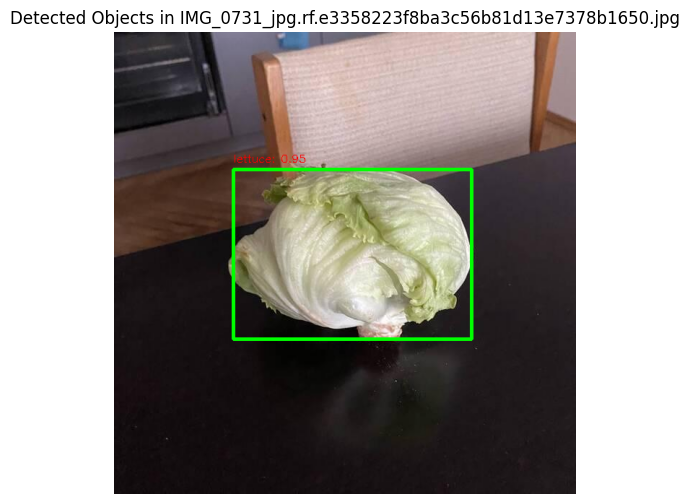


0: 640x640 1 lettuce, 277.0ms
Speed: 5.1ms preprocess, 277.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/Image_15_jpg.rf.cb774018076f268a726c51f63179062b.jpg


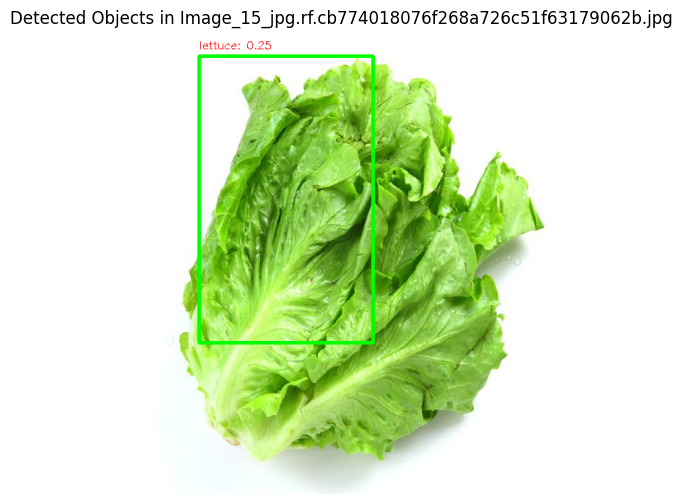


0: 640x640 2 lettuces, 236.5ms
Speed: 4.2ms preprocess, 236.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/164_JPG_jpg.rf.795c2bca7fe9bdd656cccc0352120ace.jpg


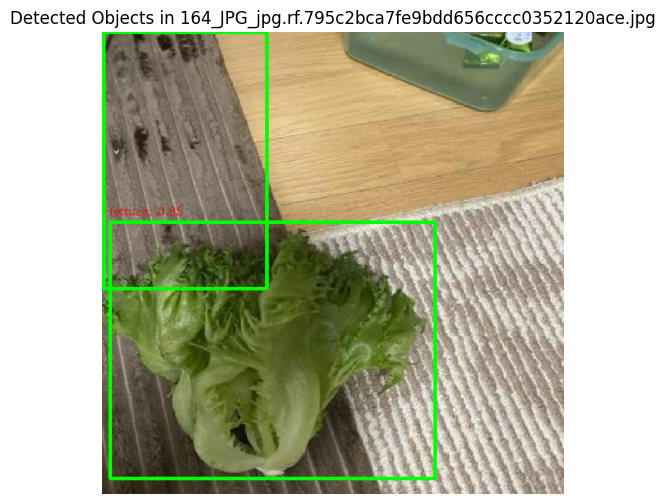


0: 640x640 1 lettuce, 275.1ms
Speed: 7.5ms preprocess, 275.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/Lettuce/test/images/Image_45_jpg.rf.4299948d7e09477ff1e7cc23c4b9164c.jpg


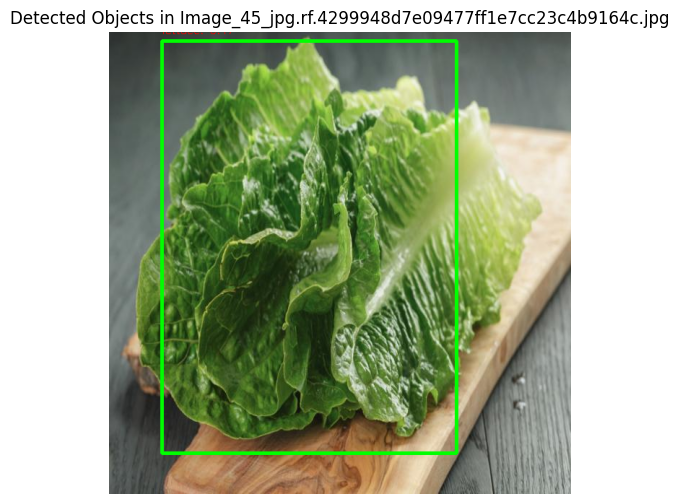

In [ ]:
for img_path in test_paths[:4]:
    detected_image = detect_objects(img_path)
    if detected_image is None:
        continue

    # Display detected image
    plt.figure(figsize=(6, 6))
    plt.imshow(detected_image)
    plt.axis('off')
    plt.title(f'Detected Objects in {os.path.basename(img_path)}')
    plt.show()
